<a href="https://colab.research.google.com/github/StillWork/book6/blob/master/gh_perf_4_CreditCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신용카드 도용 탐지

- 2013년 유럽의 카드 사용 내역 (2일간)
- 로지스틱 회귀
- 랜덤 포레스트
- LightGBM
- 데이터 전처리 (로그변환)
- 이상치 탐지
- 불균형 데이터 처리 (SMORT)

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
            roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, \
           precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

- 데이터 다운로드 66M

In [30]:
!curl -L https://bit.ly/2nweJrO -o credit.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0   1860      0 --:--:-- --:--:-- --:--:--  1884
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1034    0  1034    0     0    956      0 --:--:--  0:00:01 --:--:--   956
100 65.9M  100 65.9M    0     0  28.2M      0  0:00:02  0:00:02 --:--:-- 69.9M


In [31]:
!unzip -o credit.csv.zip

Archive:  credit.csv.zip
  inflating: creditcard.csv          


- 판다스 데이터 프레임으로 읽기

In [32]:
card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [33]:
card_df.shape

(284807, 31)

In [34]:
card_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

- 284,807개 중에 492개의 도용 데이터 (0.172%):불균형 데이터
- 차원축소된 (암호화된) (PCA:Priciple Component Analysis) 데이터 제공
- Time'(처음부터 초단위 경과시간), 거래액수: 'Amount'
- 목적변수, 'Class' 1이면 도용
- Time 컬럼 삭제

In [0]:
card_df = card_df.drop('Time', axis=1)

## 훈련 데이터, 검증 데이터 나누기
- 마지막 컬럼이 목적변수(y)이며 이의 분포에 맞게 계층적 샘플링 (stratified)을 수행한다


In [0]:
X = card_df.iloc[:, :-1]
y = card_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    random_state=9, stratify=y)

In [37]:
print('Train Data Fraud Ratio: ',(y_train == 1).mean().round(5))
print('Test Data Fraud Ratio: ',(y_test == 1).mean().round(5))

Train Data Fraud Ratio:  0.00173
Test Data Fraud Ratio:  0.00173


## 로지스틱 회귀
- 모델 생성 및 학습 수행

In [38]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 성능평가
- 컨퓨전 매트릭스 보기
- 분류 성능 평가 (정확도, 리콜, 정밀도, F-1 점수)
- ROC, AUC, Precesion-Recall 그래프
 - 실제값: y_test
 - 예측값: y_pred

- 자주 사용하는 기능을 함수로 정의

In [0]:
def conf_matrix(y_test, y_pred):
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

def draw_roc(y_test, score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, score)
  roc_auc = roc_auc_score(y_test, score)
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, label='AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  
def draw_pr(y_test, score):
  pre = dict()
  rcl = dict()
  ap = dict()
  pre, rcl, _ = precision_recall_curve(y_test, score)
  ap = average_precision_score(y_test, score)
  plt.figure(figsize=(6,6))
  plt.plot(rcl, pre, label='AP = %0.4f)' % ap)
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc="lower right")

- 로지스틱 회귀 모델을 사용한 예측 수행
- 컨퓨전 매트릭스 및 최적의 성능 평가

In [40]:
y_pred = lr_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71075     4]
 [   46    77]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.63      0.75       123

    accuracy                           1.00     71202
   macro avg       0.97      0.81      0.88     71202
weighted avg       1.00      1.00      1.00     71202



- 정확도는 거의 1이 나오지만, 1 (카드도용)에 대한 리콜 값이 0.63으로 낮다
- 123개의 1중 77개를 찾았다 (77/123 = 0.63)

## ROC
- 먼저 분류 확률 (또는 점수)를 구한다

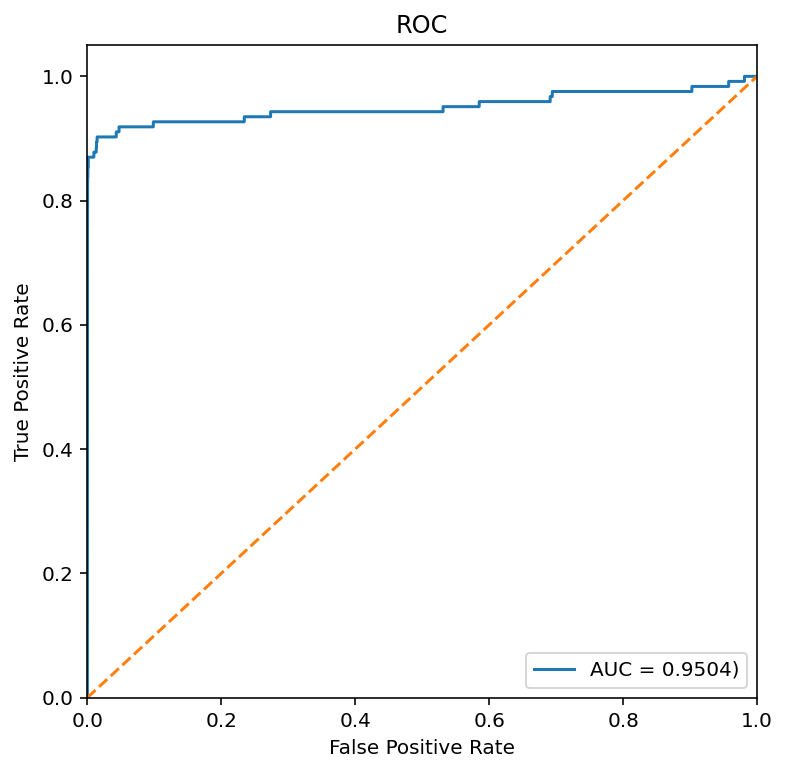

In [41]:
score = lr_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

In [42]:
X_test.shape, y_test.shape   

((71202, 29), (71202,))

In [43]:
 y_test.value_counts()

0    71079
1      123
Name: Class, dtype: int64

In [58]:
Z = pd.DataFrame(np.vstack((y_test.values, y_pred, score)).T, 
                 columns=['y','y_pred','score'])
Z[:3]

,y,y_pred,score
0,0.0,0.0,0.000276
1,0.0,0.0,0.000132
2,0.0,0.0,0.000747


- 불법 사용이라고 주장한 갯수는 81개이다

In [75]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([71121,    81]))

In [76]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([71079,   123]))

- 점수가 높은 순으로 (1이라고 판단할 점수) 150개만 그려보겠다

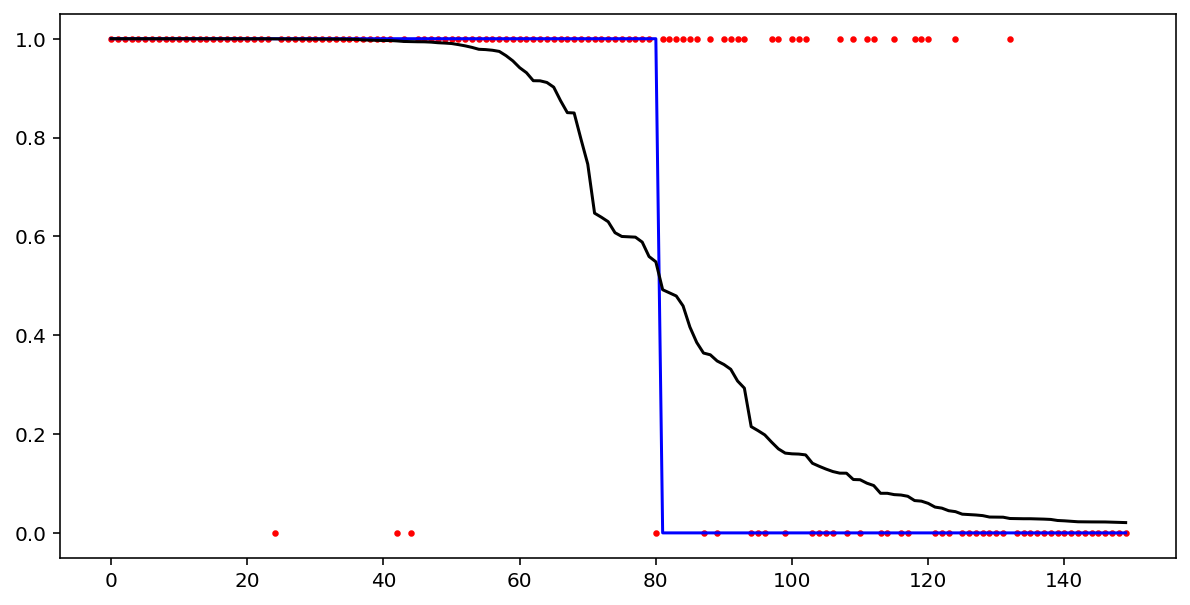

In [92]:
Z = Z.sort_values(by=['score'], ascending=False)
plt.figure(figsize=(10,5))
plt.scatter(range(150), Z['y'].values[:150], c='r', s=5)
plt.plot(Z['y_pred'].values[:150], c='b')
plt.plot(Z['score'].values[:150], c='k')


## 랜덤 포레스트

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=30)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [94]:
y_pred = rf_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71078     1]
 [   28    95]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.99      0.77      0.87       123

    accuracy                           1.00     71202
   macro avg       0.99      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



- 1에 대한 리콜이 77%로 올라갔다

## LightGBM
- 학습시에 불균형 데이터이면 반드시 boost_from_average=False로 설정해야 한다

In [95]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=300,boost_from_average=False)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [96]:
y_pred = lgbm_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71077     2]
 [   23   100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.81      0.89       123

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.94     71202
weighted avg       1.00      1.00      1.00     71202



- 리콜이 81%로 증가했다

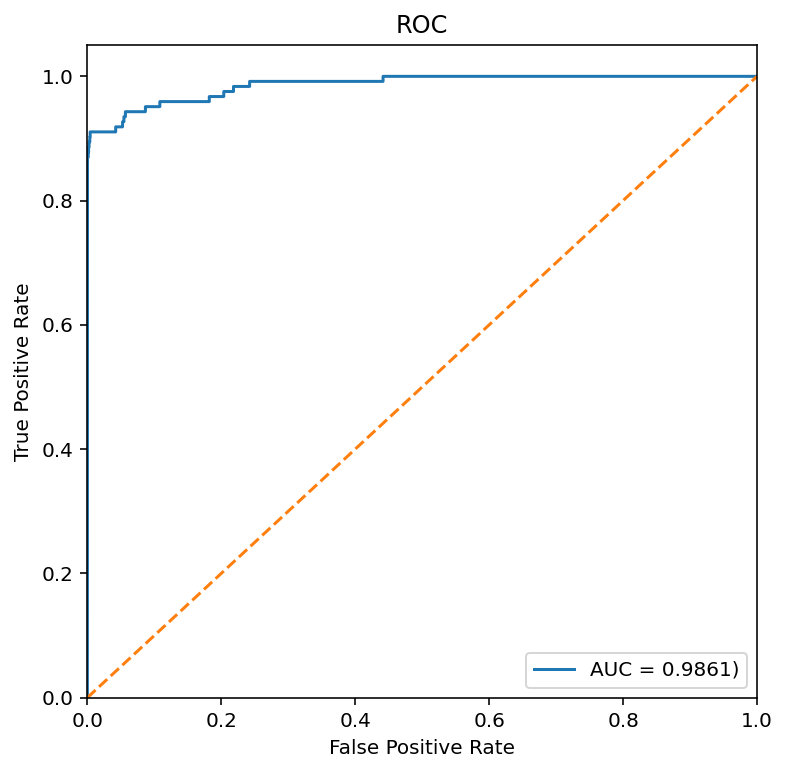

In [97]:
score = lgbm_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

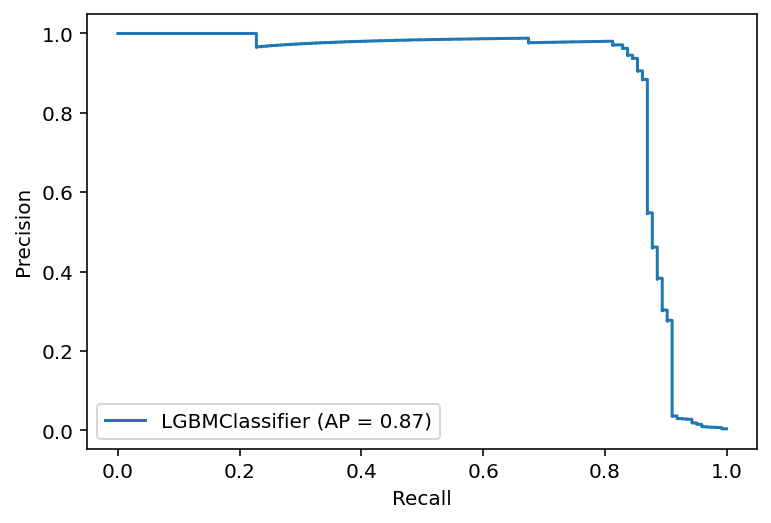

In [98]:
plot_precision_recall_curve(lgbm_clf, X_test, y_test)

In [99]:
X[:3]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


# 데이터 전처리
- 로그변환
- 스케일링
- 이상치 제거


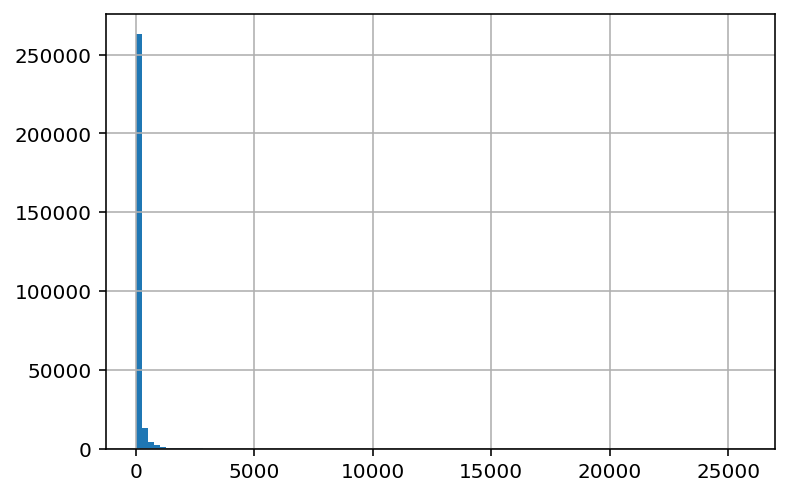

In [100]:
X['Amount'].hist(bins=100)

In [101]:
X['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

- 돈관 관련된 데이터를 로그 변환을 한 후 스케일링을 한다

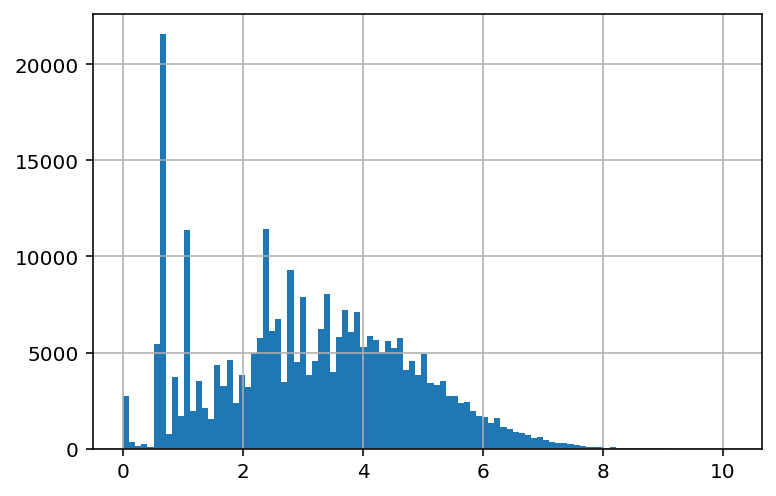

In [102]:
# log (1+x)
amount_log = np.log1p(X['Amount'])
amount_log.hist(bins=100)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
amount_sc = scaler.fit_transform(amount_log.values.reshape(-1,1))

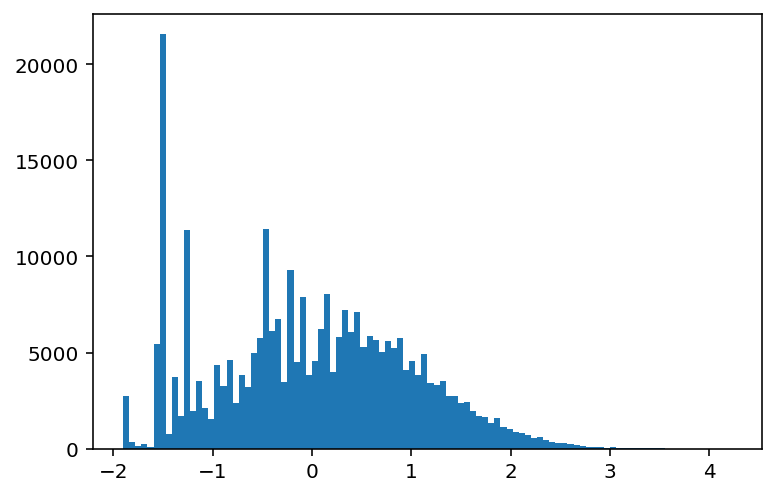

In [104]:
plt.hist(amount_sc, bins=100)
plt.show()

- 로그변환, 스케일링된 Amount를 사용한다
- 입력 데이터 (X)를 X_sc로 대체한다

In [105]:
X_sc = X.copy()
X_sc['Amount'] = amount_sc
X_sc[:3]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.124303
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.114639
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.682368


- 로지스틱 회귀 및 LightGBM 수행. 


- 아래에서 X_sc를 사용하는 것에 주의!
- 나머지 코드는 변화가 없다

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,
                random_state=9, stratify=y)

In [107]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71075     4]
 [   54    69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.56      0.70       123

    accuracy                           1.00     71202
   macro avg       0.97      0.78      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [108]:
lgbm_clf = LGBMClassifier(n_estimators=300, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71077     2]
 [   23   100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.81      0.89       123

    accuracy                           1.00     71202
   macro avg       0.99      0.91      0.94     71202
weighted avg       1.00      1.00      1.00     71202



## 이상치 처리
- 이상치는 오류가 아니다. 그러나 분석에 방해가 된다
- 이상치를 찾는 것 자체도 목적이 될 수 있다.
- 이상치를 제거하면 분석 성능이 좋아진다
  - 박스 플롯에서 확인할 수 있는 IRQ를 사용할 수 있다
  - 3 시그마 이상 떨어진 데이터를 파악할 수 있다
  - 머신러닝으로 이상치를 분류할 수 있다
- 목적 변수와 상관관계가 큰 특성부터 파악한다 (특성이 많을 때)

- 모든 특성들 간의 상관관계를 본다

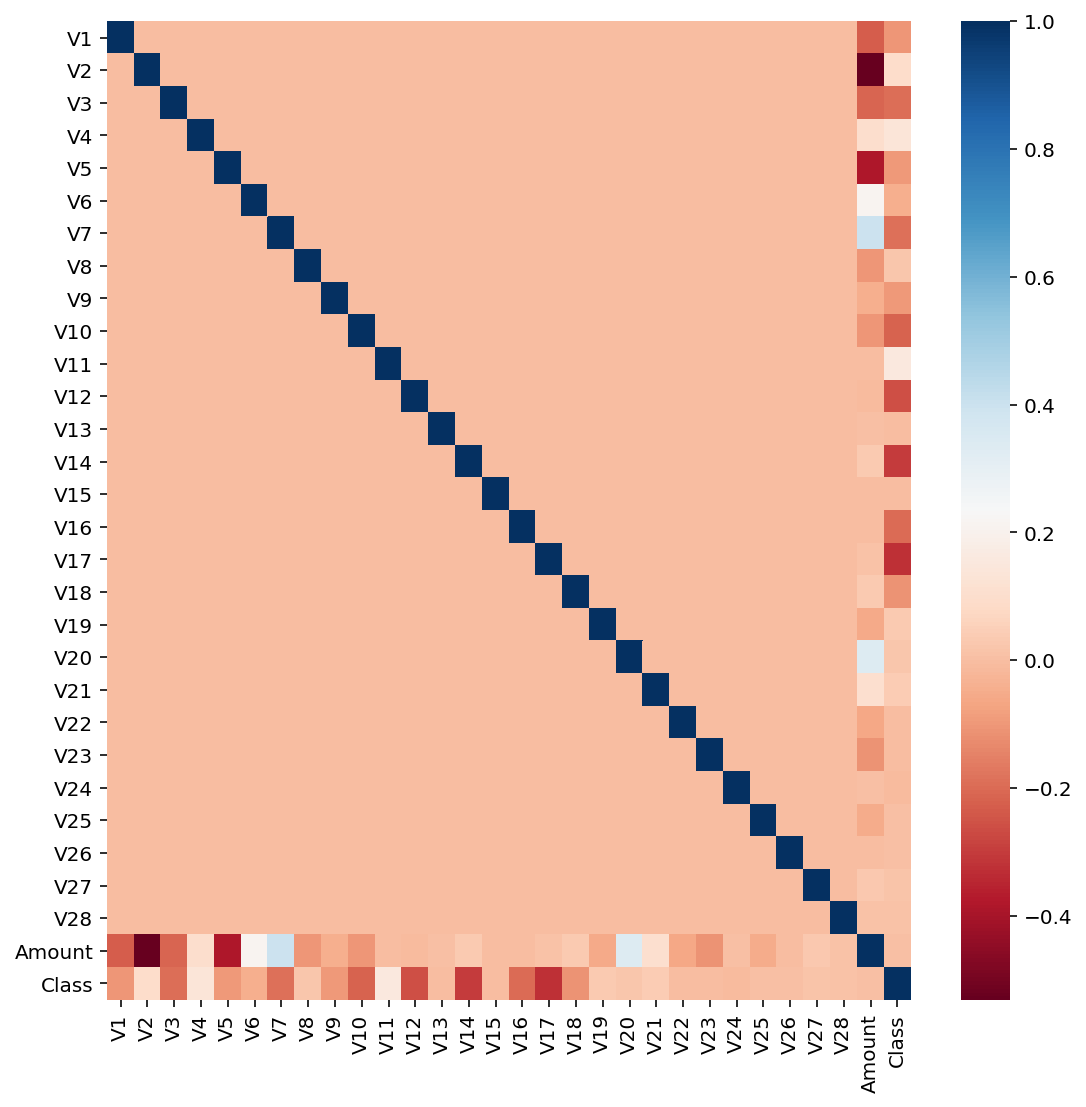

In [110]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

## 이상치 탐지 함수

In [0]:
import numpy as np

def get_outlier(df, column, weight=1.5):
    # fraud에 해당하는 column 데이터에서, 1/4 분위와 3/4 분위 지점을 np.percentile로 구한다
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구한다
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [112]:
# V14의 아웃라이어 인덱스
outlier_v14 = get_outlier(df=card_df, column='V14', weight=1.5)
outlier_v14

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

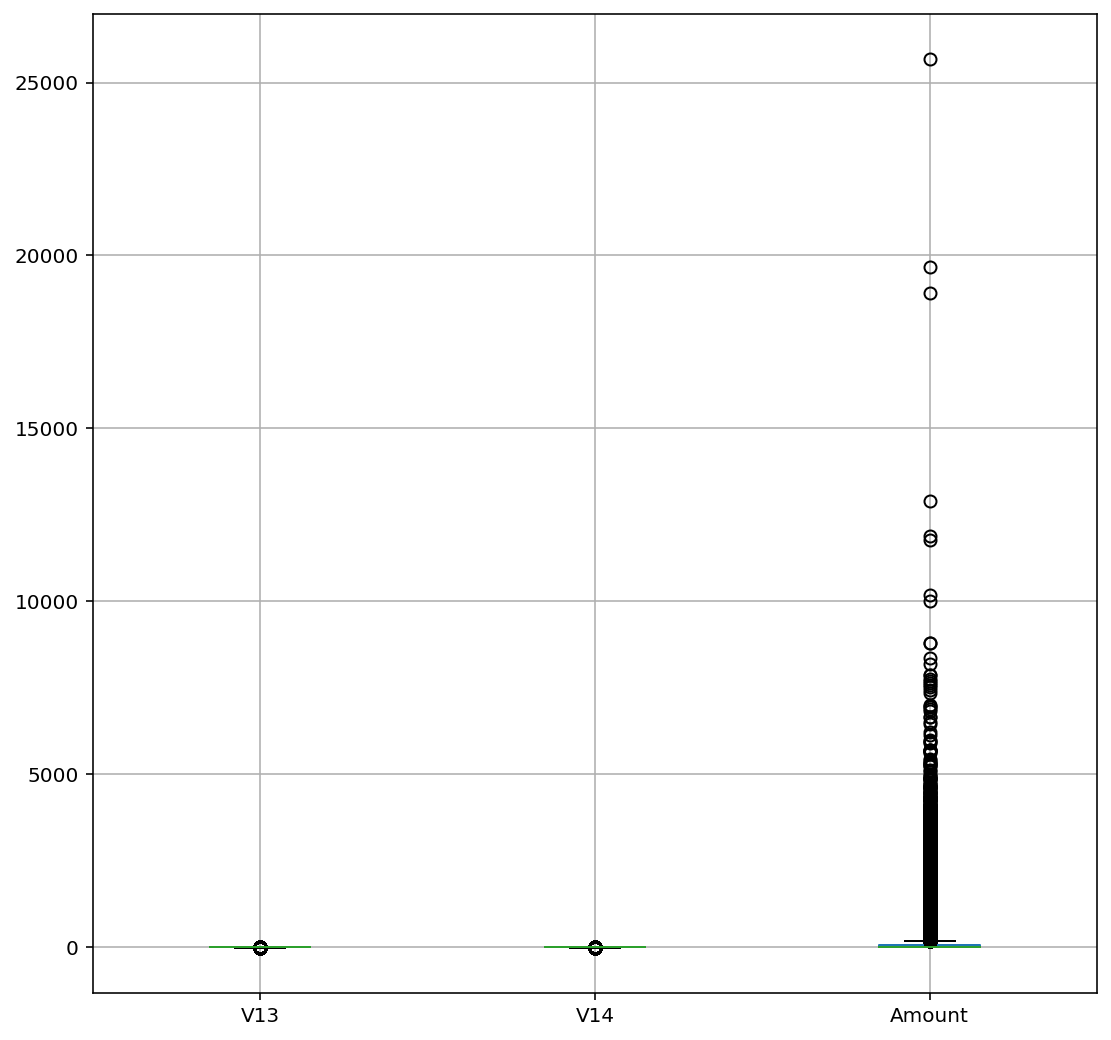

In [113]:
plt.figure(figsize=(9, 9))
X[['V13','V14','Amount']].boxplot()

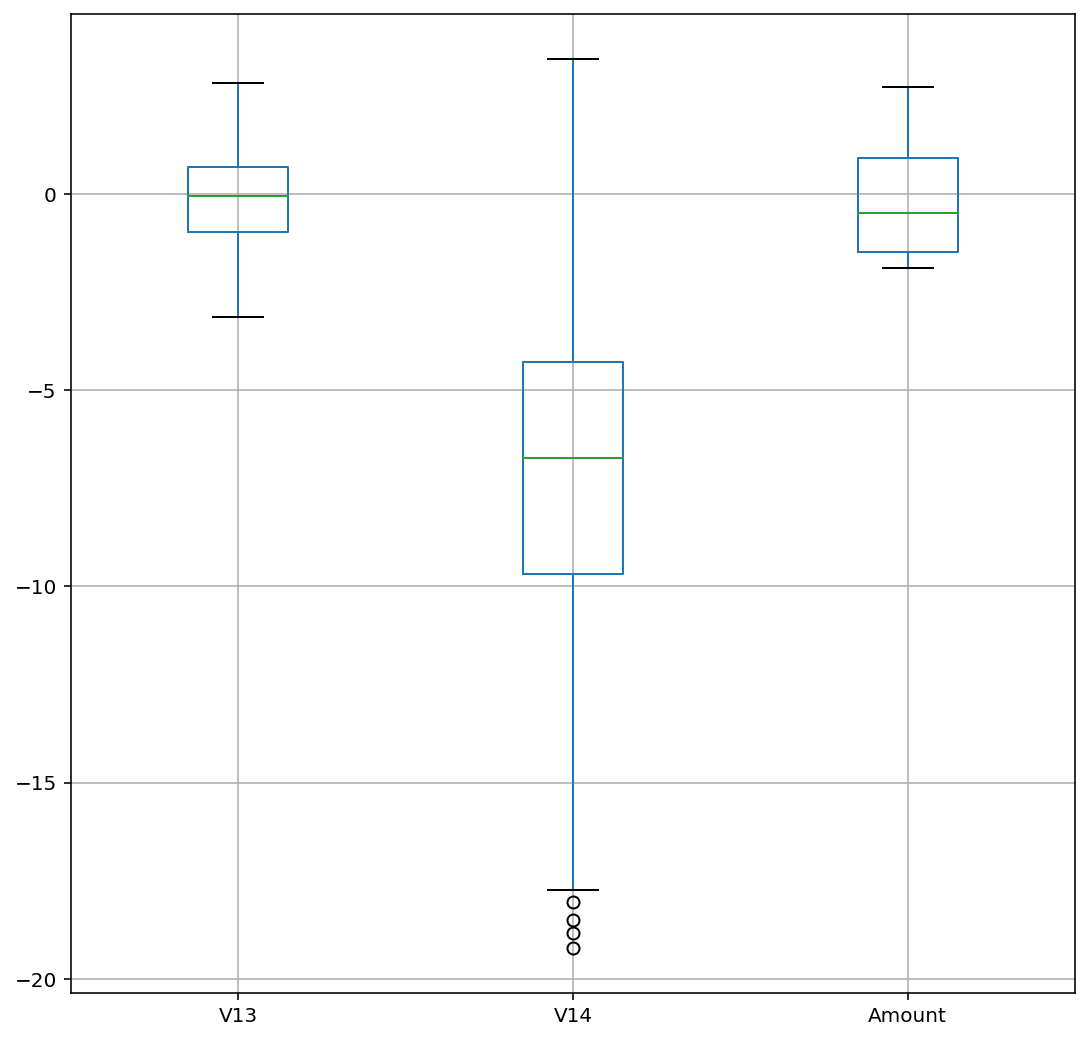

In [114]:
plt.figure(figsize=(9, 9))
X_sc[['V13','V14','Amount']][card_df['Class']==1].boxplot()

In [0]:
# V14 특성의 이상치만 삭제
# 해당 y 값도 바꾸어야 한다 (주의)
X_sc.drop(outlier_v14, inplace=True, errors='ignore')
y = y.drop(outlier_v14, errors='ignore')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, 
      random_state=9, stratify=y)

In [117]:
lgbm_clf = LGBMClassifier(n_estimators=300, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71077     2]
 [   23    99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.98      0.81      0.89       122

    accuracy                           1.00     71201
   macro avg       0.99      0.91      0.94     71201
weighted avg       1.00      1.00      1.00     71201



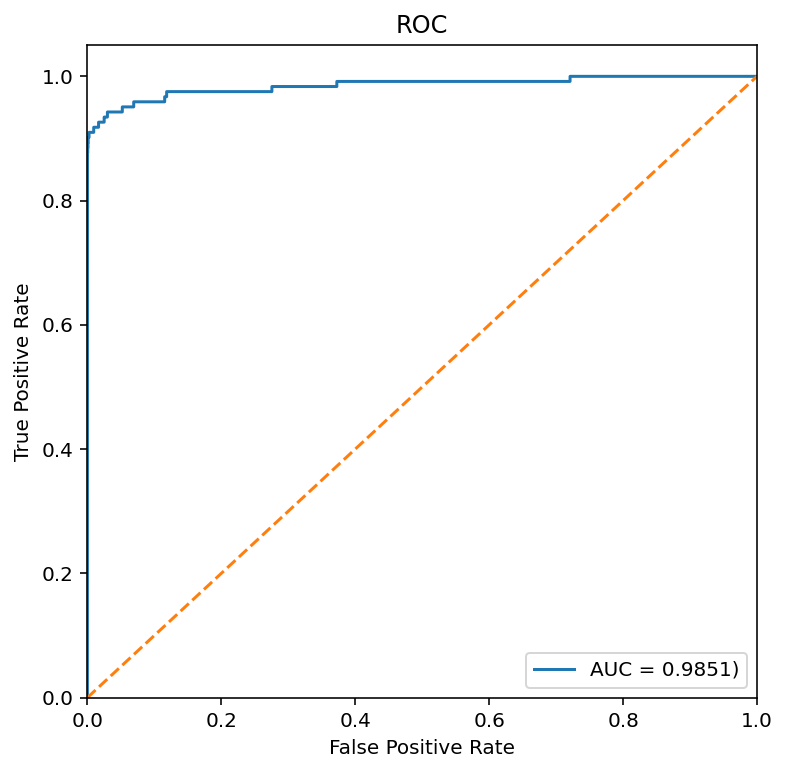

In [118]:
score = lgbm_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

# 데이터 불균형
- 주로 오버샘플링을 한다 (언더 샘플링은 작은 수에 맞추는 것)
- 데이터 증식이 필요하다
- SMOTE(Synthetic Minority Over sampling Technique)
 - k 인접 샘플을 찾아서 사이의 값들을 추가로 사용한다
 - 파이썬의 imbalanced-learn 패키지 사용
- 선형 모델은 중요 특성들이 정규 분포를 가질 때 가장 잘 동작한다
- SMOTE 오버 샘플링은 학습 데이터에만 적용해야 한다

In [119]:
y_train.value_counts()

0    213236
1       366
Name: Class, dtype: int64

In [120]:
y.shape, y_train.shape, y_test.shape

((284803,), (213602,), (71201,))

In [121]:
X_sc.shape, X_train.shape, X_test.shape

((284803, 29), (213602, 29), (71201, 29))

In [122]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=9)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
X_train_over.shape, y_train_over.shape

((426472, 29), (426472,))

- 0과 1의 갯수를 큰 쪽에 맞추어 오버샘플링했다

In [123]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([213236, 213236]))

## 학습만 오버 샘플로 수행한다
- 검증은 원래의 데이터로만

In [124]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_over, y_train_over)
y_pred = lr_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[69119  1960]
 [    8   114]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.05      0.93      0.10       122

    accuracy                           0.97     71201
   macro avg       0.53      0.95      0.54     71201
weighted avg       1.00      0.97      0.98     71201



- 1에 대한 리콜이 크게 향상되었지만 정밀도는 떨어진 것을 알 수 있다
- 정밀도 0.05는 매우 낮다

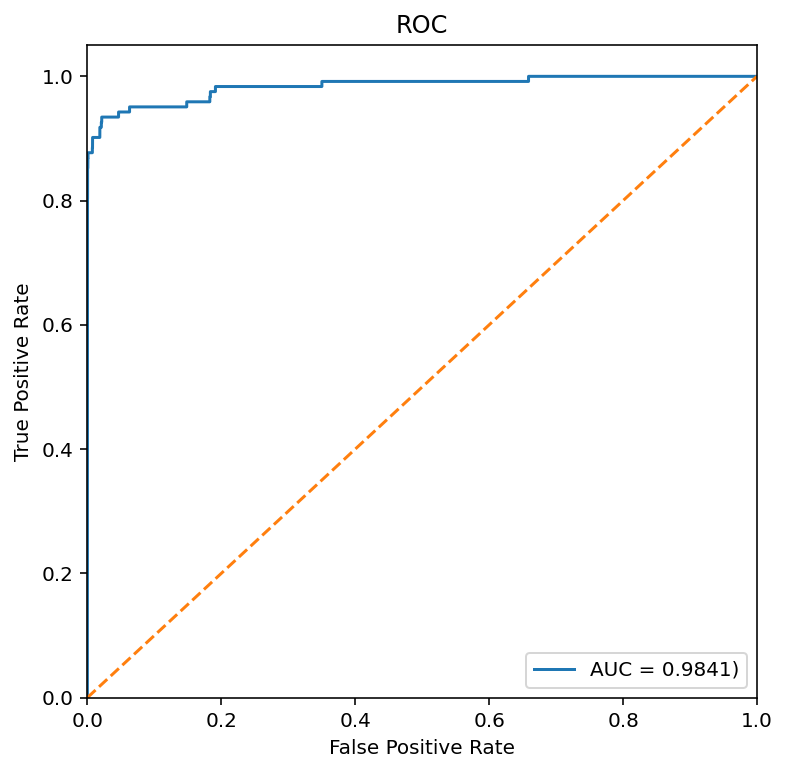

In [125]:
score = lr_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

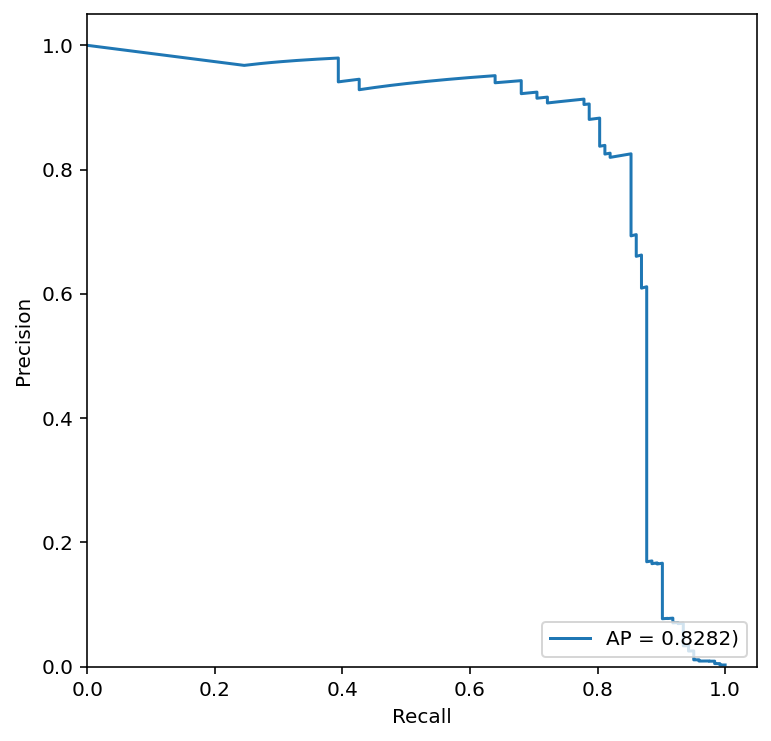

In [131]:
draw_pr(y_test, score)

- LightGBM 사용
- 오버 샘플을 사용한다

In [133]:
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=300,boost_from_average=False)
lgbm_clf.fit(X_train_over, y_train_over)

LGBMClassifier(boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=31, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [134]:
y_pred = lgbm_clf.predict(X_test)
conf_matrix(y_test, y_pred)

[[71061    18]
 [   17   105]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.85      0.86      0.86       122

    accuracy                           1.00     71201
   macro avg       0.93      0.93      0.93     71201
weighted avg       1.00      1.00      1.00     71201



- LightGBM을 사용하여 리콜도 높이고(0.86) 정밀도도 높였다 (0.85)

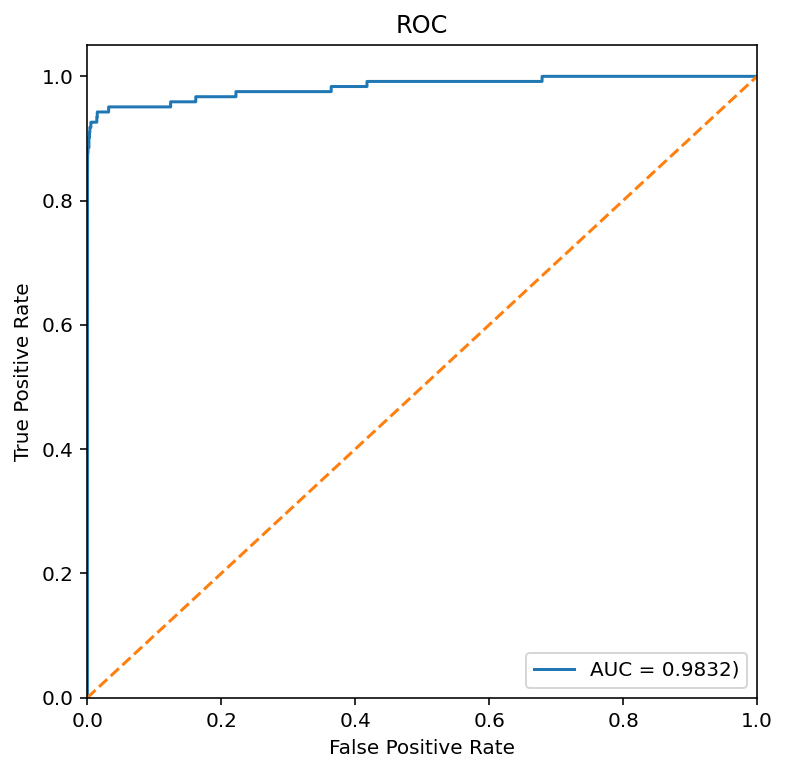

In [135]:
score = lgbm_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, score)

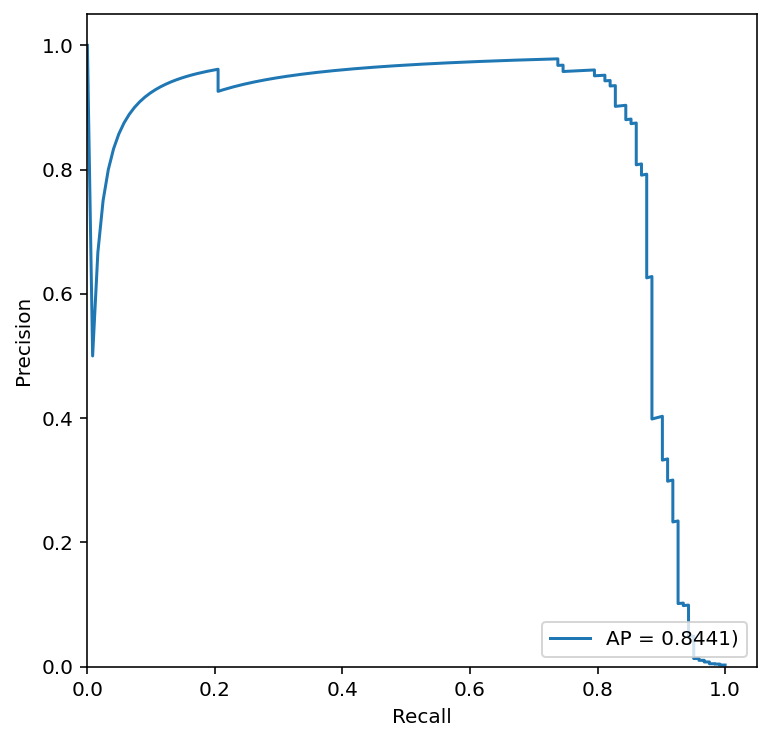

In [136]:
# score = lgbm_clf.predict_proba(X_test)[:,1]
draw_pr(y_test, score)

# plot_precision_recall_curve(lgbm_clf, X_test, y_test)